# Setup

In [ ]:
# Image from Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --quiet -U --no-cache-dir gdown --pre
!pip install --quiet shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 10.8 MB/s eta 0:00:00


In [ ]:
import string
import re
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.backend as K

import nltk

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

nltk.download('punkt')

import seaborn as sns # untuk visualisasi
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

# potongan kode di bawah adalah agar gambar graph yang 
# dihasilkan mempunyai kualitas yang cukup baik
sns.set(rc={"figure.dpi":100, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
!pip install --quiet catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.0 MB/s eta 0:00:00


In [ ]:
import sklearn

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import cross_val_score

from catboost import CatBoostRegressor, CatBoostClassifier, Pool

from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification

from sklearn.svm import LinearSVC, SVC
from mlxtend.plotting import plot_decision_regions

import shap

In [ ]:
abusive_lexicon = pd.read_csv('/content/drive/MyDrive/Tugas Akhir/Data/abusive.csv')
dataset = pd.read_csv('/content/drive/MyDrive/Tugas Akhir/Data/re_dataset.csv', encoding='latin-1')

eda_data = pd.read_csv('/content/drive/MyDrive/Tugas Akhir/Data/eda_sample.csv', encoding='latin-1')
model_data = pd.read_csv('/content/drive/MyDrive/Tugas Akhir/Data/model_data.csv', encoding='latin-1')

kamus_alay = pd.read_csv('/content/drive/MyDrive/Tugas Akhir/Data/kamusalay.csv', encoding='latin-1')
potensi_bias = pd.read_csv('/content/drive/MyDrive/Tugas Akhir/Data/potensi_bias.csv', encoding='latin-1')

ex_features_df = pd.read_csv('/content/drive/MyDrive/Tugas Akhir/Data/extracted_feature.csv', encoding='latin-1')

In [ ]:
ex_features_df = ex_features_df.loc[:, ex_features_df.columns != 'Unnamed: 0']

In [ ]:
eda_data

Unnamed: 0  dataset_id  \
0              0        2463   
1              1        2394   
2              2         340   
3              3         465   
4              4        4865   
...          ...         ...   
3287        3287        8161   
3288        3288         123   
3289        3289        7547   
3290        3290        9799   
3291        3291        2277   

                                                  Tweet  HS  Abusive  \
0     Faham betui betui maksud menegakkan agama Alla...   0        0   
1     Akankah Partai Bulan Bintang akan semakin meng...   0        0   
2     USER Tu yang saya katakan sejak dulu lagi kita...   0        0   
3     USER aku gakuat karna jijik makanya ku cepetin...   0        0   
4     Jd selama bininya om gue hamil, kunti ini udh ...   0        0   
...                                                 ...  ..      ...   
3287  USER keluarga halilintar hmm masa km gatau. udik'   1        1   
3288  #2019GantiPresiden scra konstitusional hak set...   1        1   
3289  USER si ahok pantasnya dinobatkan sbgai Babi n...   1        1   
3290  YA ALLAH INI XL GAK KURANG KAMPRET LAGI APA KO...   1        1   
3291  USER Den...den...\nNista banget hidup lo..\nUd...   1        1   

      HS_Individual  HS_Group  HS_Religion  HS_Race  HS_Physical  HS_Gender  \
0                 0         0            0        0            0          0   
1                 0         0            0        0            0          0   
2                 0         0            0        0            0          0   
3                 0         0            0        0            0          0   
4                 0         0            0        0            0          0   
...             ...       ...          ...      ...          ...        ...   
3287              1         0            0        0            0          0   
3288              1         0            0        0            0          0   
3289              1         0            0        0            0          0   
3290              0         1            0        0            0          0   
3291              1         0            0        0            0          0   

      HS_Other  HS_Weak  HS_Moderate  HS_Strong  
0            0        0            0          0  
1            0        0            0          0  
2            0        0            0          0  
3            0        0            0          0  
4            0        0            0          0  
...        ...      ...          ...        ...  
3287         1        1            0          0  
3288         1        1            0          0  
3289         1        1            0          0  
3290         1        0            1          0  
3291         1        1            0          0  

[3292 rows x 15 columns]

In [ ]:
ex_features_df

Tweet  Exclamation  Abusive  \
0     Faham betui betui maksud menegakkan agama Alla...            0        0   
1     Akankah Partai Bulan Bintang akan semakin meng...            0        0   
2     USER Tu yang saya katakan sejak dulu lagi kita...            0        0   
3     USER aku gakuat karna jijik makanya ku cepetin...            0        1   
4     Jd selama bininya om gue hamil, kunti ini udh ...            0        1   
...                                                 ...          ...      ...   
3287  USER keluarga halilintar hmm masa km gatau. udik'            0        1   
3288  #2019GantiPresiden scra konstitusional hak set...            1        0   
3289  USER si ahok pantasnya dinobatkan sbgai Babi n...            0        1   
3290  YA ALLAH INI XL GAK KURANG KAMPRET LAGI APA KO...            0        1   
3291  USER Den...den...\nNista banget hidup lo..\nUd...            0        1   

      jokowi  islam  indonesia  prabowo  cina  ahok  presiden  ...  muka  \
0          0      0          0        0     0     0         0  ...     0   
1          0      0          0        0     0     0         0  ...     0   
2          0      0          0        0     1     0         0  ...     0   
3          0      0          0        0     0     0         0  ...     0   
4          0      0          0        0     0     0         0  ...     0   
...      ...    ...        ...      ...   ...   ...       ...  ...   ...   
3287       0      0          0        0     0     0         0  ...     0   
3288       0      0          0        0     0     0         0  ...     0   
3289       0      0          0        0     0     1         0  ...     0   
3290       0      0          0        0     0     0         0  ...     0   
3291       0      0          0        0     0     0         0  ...     0   

      paksa  lanjut  bandara  menteri  Length  Words  Uppercase  All Caps  HS  
0         0       0        0        0      74      6          2         0   0  
1         0       0        0        0      77      6          4         0   0  
2         0       0        0        0     135      9          6         0   0  
3         0       0        0        0     133     10          4         0   0  
4         0       0        0        0     174     14          2         0   0  
...     ...     ...      ...      ...     ...    ...        ...       ...  ..  
3287      0       0        0        0      49      5          4         0   1  
3288      0       0        0        0     118     11          3         0   1  
3289      0       0        0        0      52      5          5         0   1  
3290      0       0        0        0      61      5         49         1   1  
3291      0       0        0        0     232     23         12         0   1  

[3292 rows x 391 columns]

In [ ]:
ex_features_df['HS'] = eda_data['HS']
ex_features_df['A'] = eda_data['Abusive']

In [ ]:
features_df = ex_features_df.loc[:, ex_features_df.columns != 'Tweet']
features_df = features_df.loc[:, features_df.columns != 'HS']
features_df = features_df.loc[:, features_df.columns != 'A']

In [ ]:
features_df

Exclamation  Abusive  jokowi  islam  indonesia  prabowo  cina  ahok  \
0               0        0       0      0          0        0     0     0   
1               0        0       0      0          0        0     0     0   
2               0        0       0      0          0        0     1     0   
3               0        1       0      0          0        0     0     0   
4               0        1       0      0          0        0     0     0   
...           ...      ...     ...    ...        ...      ...   ...   ...   
3287            0        1       0      0          0        0     0     0   
3288            1        0       0      0          0        0     0     0   
3289            0        1       0      0          0        0     0     1   
3290            0        1       0      0          0        0     0     0   
3291            0        1       0      0          0        0     0     0   

      presiden  kpk  ...  bangga  muka  paksa  lanjut  bandara  menteri  \
0            0    0  ...       0     0      0       0        0        0   
1            0    0  ...       0     0      0       0        0        0   
2            0    0  ...       0     0      0       0        0        0   
3            0    0  ...       0     0      0       0        0        0   
4            0    0  ...       0     0      0       0        0        0   
...        ...  ...  ...     ...   ...    ...     ...      ...      ...   
3287         0    0  ...       0     0      0       0        0        0   
3288         0    0  ...       0     0      0       0        0        0   
3289         0    0  ...       0     0      0       0        0        0   
3290         0    0  ...       0     0      0       0        0        0   
3291         0    0  ...       0     0      0       0        0        0   

      Length  Words  Uppercase  All Caps  
0         74      6          2         0  
1         77      6          4         0  
2        135      9          6         0  
3        133     10          4         0  
4        174     14          2         0  
...      ...    ...        ...       ...  
3287      49      5          4         0  
3288     118     11          3         0  
3289      52      5          5         0  
3290      61      5         49         1  
3291     232     23         12         0  

[3292 rows x 389 columns]

## feats

In [ ]:
# HS Features
top_n_hs = [
 ('cebong', 110.34811441960026),
 ('2019gantipresiden', 75.90069314600002),
 ('Exclamation', 70.55371595026722),
 ('jokowi', 63.371015645395964),
 ('prabowo', 54.86108861723573),
 ('ahok', 53.125796943099495),
 ('lengser', 42.777155871476005),
 ('Length', 36.84098374032803),
 ('Abusive', 35.469689057989),
 ('budaya', 34.90252416756176),
 ('tolol', 33.53126063723237),
 ('goblok', 33.463208660821344),
 ('Uppercase', 32.61247054509399),
 ('bubar', 29.583672984510986),
 ('dungu', 28.192095154682843),
 ('kampret', 25.453576436951316),
 ('bani', 25.453576436951316),
 ('dasar', 25.231513174062865),
 ('Words', 24.62759681765306),
 ('kafir', 24.564368023774918),
 ('otak', 23.521747205193947),
 ('katolik', 22.98481959802605),
 ('tipu', 21.29015625192861),
 ('bom', 21.069816411923135),
 ('biadab', 18.96557774364226),
 ('ekonomi', 18.55243737936092),
 ('kristen', 17.574428491215734),
 ('pki', 16.518813009230392),
 ('pilkada', 16.334821106469022),
 ('sontoloyo', 16.221324924819715),
 ('usir', 14.757229608394622),
 ('ngentot', 14.428125216807064),
 ('jawa', 14.428125216807064),
 ('cina', 14.316203993907742),
 ('yahudi', 13.962936525388983),
 ('hindu', 13.657753624378143),
 ('picek', 13.488824794728739),
 ('munafik', 12.658269845589082),
 ('nista', 12.563964219047698),
 ('rakyat', 12.379494305520401),
 ('asing', 12.36720412271323),
 ('sipit', 12.242350547041795),
 ('sby', 12.227681688589335),
 ('anies', 12.227681688589335),
 ('swt', 12.227681688589335),
 ('anies-sandi', 12.126958419731528),
 ('keparat', 12.126958419731528),
 ('pilih kepala daerah', 12.120723073700699),
 ('bangsat', 11.917097349474046),
 ('hancur', 11.917097349474046),
 ('tukang', 11.917097349474046),
 ('2018', 11.833752616444313),
 ('alam', 11.354058156167763),
 ('cewek', 11.081932759468454),
 ('kpk', 10.985124834688929),
 ('anjing', 10.558503723385709),
 ('kontol', 10.550765287814363),
 ('temu', 10.359741447128847),
 ('bacot', 10.259729735456526),
 ('kaum', 10.259729735456526),
 ('gubernur', 10.15230225715779),
 ('bajing', 9.8784526034065),
 ('tingkat', 9.824414210128495),
 ('korupsi', 9.365197784332462),
 ('komunis', 9.306022442876644),
 ('wkwk', 9.293863998507947),
 ('hina', 9.212676473902215),
 ('cocot', 9.166008983142897),
 ('memek', 9.135252718767692),
 ('rezim', 8.588506539575318),
 ('bapak', 8.566477414978369),
 ('tangkap', 8.55629534273258),
 ('cacat', 8.184967172438588),
 ('sandi', 8.114389642031412),
 ('myanmar', 8.058781892287833),
 ('bong', 8.058781892287833),
 ('umat', 8.003339444735863),
 ('anjir', 7.8687842013719616),
 ('All Caps', 7.78898551574197),
 ('buaya', 7.539118818324024),
 ('bego', 7.479306439820447),
 ('kayak', 7.362203594452939),
 ('bisu', 7.339305705539183),
 ('titit', 7.339305705539183),
 ('bangun', 7.0629399325201705),
 ('tka', 6.835304245647373),
 ('an', 6.6015073588477176),
 ('dpr', 6.424447096363063),
 ('teriak', 6.424447096363063),
 ('congor', 6.226864258327995),
 ('berani', 6.226864258327995),
 ('mu', 6.226864258327995),
 ('citra', 6.226864258327995),
 ('masyarakat', 6.146039642845457),
 ('babi', 6.060842695503713),
 ('bangkai', 6.059474231273955),
 ('bahasa', 6.059474231273955),
 ('islam', 6.0089486417564935),
 ('ngewe', 5.868650990363385),
 ('bodoh', 5.846977175607727),
 ('bela', 5.756227882921352),
 ('sekolah', 5.725593417401544),
 ('dengar', 5.725593417401544),
 ('antek', 5.6963070161213505),
 ('geblek', 5.683811250175008),
 ('teman', 5.3827815686689195),
 ('rohingya', 5.361090365224104),
 ('kunti', 5.264757854231538),
 ('bejat', 5.113139692929426),
 ('banyak', 5.113139692929426),
 ('lu', 5.113139692929426),
 ('idiot', 4.896896702021349),
 ('cinta', 4.896896702021349),
 ('takut', 4.896896702021349),
 ('nusantara', 4.793343394228391),
 ('hal', 4.68854049625912),
 ('arab', 4.68854049625912),
 ('lanjut', 4.68854049625912),
 ('lesbi', 4.509053852616743),
 ('edan', 4.436132363569043),
 ('tulis', 4.436132363569043),
 ('pintar', 4.433757799363106),
 ('lupa', 4.422225417042576),
 ('kota', 4.422225417042576),
 ('sayang', 4.2942534796581455),
 ('onta', 4.223504369221073),
 ('malu', 4.222349848962606),
 ('habis', 4.219757859048472),
 ('pilih', 4.205384807041673),
 ('lo', 4.044727738973866),
 ('celeng', 4.038666534685073),
 ('lahir', 4.021626043877695),
 ('bukti', 3.9395050335731843),
 ('jalan', 3.8143983944773048),
 ('aman', 3.8143983944773048),
 ('pimpin', 3.7715922200041265),
 ('autis', 3.754553201322991),
 ('gendut', 3.754553201322991),
 ('buat', 3.730906008609057),
 ('janji', 3.730906008609057),
 ('nete', 3.7121295685606563),
 ('lgbt', 3.7121295685606563),
 ('beli', 3.70905155524417),
 ('dongok', 3.3999136212368546),
 ('cerita', 3.370797456168331),
 ('tuhan', 3.3563032593346906),
 ('banci', 3.2422704924007655),
 ('polisi', 3.2422704924007655),
 ('kelas', 3.211761064134776),
 ('warga', 3.185111161805482),
 ('bangsa', 3.158497094728439),
 ('aku', 3.158497094728439),
 ('buta', 3.143997578267667),
 ('monyet', 3.12851638683714),
 ('sok', 3.0971072182810566),
 ('anti', 3.0485926341658467),
 ('jamban', 3.0145439139170023),
 ('ngaceng', 3.0012530283924757),
 ('ajar', 2.8354652386848658),
 ('bunuh', 2.8053962792153384),
 ('tunggu', 2.8053962792153384),
 ('selesai', 2.74011246528556),
 ('berak', 2.674854003880392),
 ('cupu', 2.674854003880392),
 ('china', 2.654458990311588),
 ('lawan', 2.654458990311588),
 ('kepala', 2.6320554617381013),
 ('kenal', 2.6320554617381013),
 ('tolak', 2.61609664297876),
 ('rumah', 2.61609664297876),
 ('biar', 2.584697221063741),
 ('rusak', 2.405743271678149),
 ('setan', 2.3799380055695485),
 ('2019', 2.3799380055695485),
 ('mampus', 2.3491965549582714),
 ('gembel', 2.334312505136287),
 ('gay', 2.24915047099921),
 ('sange', 2.24915047099921),
 ('cari', 2.141160467753218),
 ('beda', 2.141160467753218),
 ('hilang', 2.1352542609604095),
 ('baca', 2.0885532975774357),
 ('apa', 2.0885532975774357),
 ('orang', 2.066388543764246),
 ('eh', 2.039051064472662),
 ('fitnah', 1.9581172452955873),
 ('marah', 1.8729992802532807),
 ('bang', 1.8222672481800017),
 ('surat beri tahun', 1.8222672481800017),
 ('senang', 1.793810836870813),
 ('dunia', 1.7726967093853232),
 ('kitab', 1.7558984243824687),
 ('modar', 1.6955566211412976),
 ('silit', 1.6795116844114732),
 ('ateis', 1.6795116844114732),
 ('uang', 1.6751292017774027),
 ('harga', 1.6751292017774027),
 ('mulu', 1.6751292017774027),
 ('bantu', 1.6076494981312992),
 ('no', 1.6076494981312992),
 ('taplak', 1.56443525902955),
 ('hak', 1.56443525902955),
 ('jembut', 1.498242675412765),
 ('gembrot', 1.498242675412765),
 ('lonte', 1.498242675412765),
 ('presiden', 1.4697889678022833),
 ('muslim', 1.4102638994707037),
 ('pantat', 1.39797830756791),
 ('partai', 1.3747898526749565),
 ('bawa', 1.35272484383147),
 ('bispak', 1.3360087336454554),
 ('cungkring', 1.3360087336454554),
 ('koreng', 1.3360087336454554),
 ('seks', 1.3360087336454554),
 ('serbet', 1.3360087336454554),
 ('dukung', 1.3352932676981297),
 ('negeri', 1.2241769021605318),
 ('gaji', 1.2117419020199114),
 ('langsung', 1.206872213558489),
 ('partai komunis indonesia', 1.2033748869227199),
 ('berengsek', 1.1883265039447972),
 ('muka', 1.1883265039447972),
 ('kalah', 1.1868363835032474),
 ('tak', 1.1817908542308877),
 ('butuh', 1.181462898836725),
 ('in', 1.181462898836725),
 ('ku', 1.0898461126904577),
 ('kejam', 1.0646835610936336),
 ('bandara', 1.0646835610936336),
 ('agama', 1.0558361648393257),
 ('culun', 1.0399793227694663),
 ('haha', 1.0360407229757316),
 ('amp', 1.0149578538074995),
 ('pikir', 1.002590258794752),
 ('ajak', 0.987238496113362),
 ('ganti', 0.9529182771085576),
 ('nama', 0.9470447854929663),
 ('laku', 0.9119539461189773),
 ('fiksi', 0.8795133448239209),
 ('enak', 0.8795133448239209),
 ('indonesia', 0.863349459687896),
 ('allah', 0.7782263781933868),
 ('budek', 0.7741723925292983),
 ('wakil', 0.7741723925292983),
 ('ambil', 0.7741723925292983),
 ('iman', 0.7741723925292983),
 ('tuyul', 0.7485267969621711),
 ('sitip', 0.7485267969621711),
 ('panasbung', 0.7485267969621711),
 ('sompret', 0.6978151412973321),
 ('akun', 0.6824723337284011),
 ('bayar', 0.6824723337284011),
 ('rejim', 0.6730734564921673),
 ('benar', 0.6730734564921673),
 ('buang', 0.6730734564921673),
 ('bahas', 0.6730734564921673),
 ('nyata', 0.6655411212446929),
 ('coba', 0.6655411212446929),
 ('hoaks', 0.6655411212446929),
 ('terima', 0.6655411212446929),
 ('isi', 0.6499351209575555),
 ('kampung', 0.6499351209575555),
 ('lihat', 0.6499198837711107),
 ('jancuk', 0.604327391204703),
 ('kampang', 0.604327391204703),
 ('udik', 0.604327391204703),
 ('buddha', 0.5990572251404706),
 ('jijik', 0.5886917794420856),
 ('jablay', 0.5812616064601234),
 ('kena', 0.553829773949056),
 ('milik', 0.553829773949056),
 ('kemarin', 0.553829773949056),
 ('dan lain lain', 0.553829773949056),
 ('ga', 0.553829773949056),
 ('pakai', 0.5219258990602881),
 ('ampas', 0.5189219477713409),
 ('sinting', 0.5189219477713409),
 ('transgender', 0.5189219477713409),
 ('maju', 0.5027169459407322),
 ('besar', 0.46877063948455655),
 ('makan', 0.4664957666730979),
 ('nih', 0.45815360382787496),
 ('harap', 0.4424353455058476),
 ('berita', 0.4424353455058476),
 ('anggap', 0.4424353455058476),
 ('ah', 0.3951764468134211),
 ('susah', 0.3951764468134211),
 ('suka', 0.37998408079499013),
 ('masuk', 0.373930237684931),
 ('sadar', 0.3398812201953986),
 ('tertawa', 0.3313564892037199),
 ('ulama', 0.3194533384033239),
 ('gerak', 0.2971188304577722),
 ('jadi', 0.28966689141361457),
 ('jual', 0.28966689141361457),
 ('tinggal', 0.2794069974658108),
 ('tuju', 0.27874429576307563),
 ('deh', 0.2777907241189218),
 ('kuasa', 0.2777907241189218),
 ('tau', 0.2743052932853056),
 ('ri', 0.2544360939881155),
 ('buka', 0.23849790514891414),
 ('bokong', 0.22059186595079452),
 ('paham', 0.21878433642930203),
 ('mati', 0.2118327884389553),
 ('menang', 0.18758952544075416),
 ('bangga', 0.18758952544075416),
 ('kuat', 0.1855826743982132),
 ('percaya', 0.1855826743982132),
 ('keluarga', 0.1855826743982132),
 ('utang', 0.16930869228961004),
 ('gak', 0.16239308309221592),
 ('politik', 0.1513973408094525),
 ('hidup', 0.14389847150680732),
 ('bencong', 0.12686358484234905),
 ('pecun', 0.12686358484234905),
 ('ayo', 0.1261078623242918),
 ('bilang', 0.1222699622459239),
 ('jakarta', 0.11397400809697021),
 ('anak', 0.11159592849377392),
 ('noob', 0.11014014422085706),
 ('homo', 0.11014014422085706),
 ('gila', 0.10099417605764564),
 ('tonton', 0.10099417605764564),
 ('proyek', 0.10099417605764564),
 ('paksa', 0.10099417605764564),
 ('salah', 0.0987762823165351),
 ('hati', 0.09812781599452242),
 ('usaha', 0.09244954520887085),
 ('moga', 0.09158628995731974),
 ('kerja', 0.08900367696055259),
 ('manusia', 0.08158501421353827),
 ('kalo', 0.08158501421353827),
 ('perintah', 0.0796049062328596),
 ('main', 0.0792196409830799),
 ('suci', 0.06511816992696887),
 ('selamat', 0.06511816992696887),
 ('bicara', 0.0633668407978869),
 ('enggak', 0.06333438176032172),
 ('urus', 0.059605492760204944),
 ('sakit', 0.059605492760204944),
 ('cepat', 0.059605492760204944),
 ('aduh', 0.059605492760204944),
 ('sampah', 0.048726761186433),
 ('kacrut', 0.042209457355024425),
 ('bokep', 0.042209457355024425),
 ('iblis', 0.0324102708147798),
 ('nabi', 0.03150796673508067),
 ('lucu', 0.03150796673508067),
 ('bau', 0.03150796673508067),
 ('hukum', 0.02973337224992938),
 ('negara', 0.026217724889937923),
 ('bikin', 0.02403027808666823),
 ('turun', 0.019740585586590788),
 ('diam', 0.019740585586590788),
 ('kasih', 0.01958380114471903),
 ('ikut', 0.018696306194827452),
 ('alay', 0.016168186351685133),
 ('burik', 0.016168186351685133),
 ('perek', 0.016168186351685133),
 ('tai', 0.014568551917638136),
 ('sarap', 0.009829796551859917),
 ('om', 0.009829796551859917),
 ('menteri', 0.009829796551859917),
 ('najis', 0.0064564541069301136),
 ('benci', 0.0064564541069301136),
 ('foto', 0.0064564541069301136),
 ('calon', 0.005789203298415481),
 ('bro', 0.005789203298415481),
 ('kunyuk', 0.003903982385145879),
 ('isu', 0.003903982385145879),
 ('mata', 2.9849408712603493e-05),
 ('hasil', 1.7794839710889455e-05),
 ('malam', 1.1825324761078608e-05)
]

In [ ]:
# A Features
top_n_a = [
 ('Abusive', 863.4908194062502),
 ('cebong', 148.4593090814069),
 ('Length', 79.29269942971099),
 ('Words', 59.50479688978978),
 ('goblok', 55.09732272941384),
 ('kampret', 50.05443759533496),
 ('tolol', 50.05443759533496),
 ('anjir', 46.712693784996986),
 ('kontol', 41.73005782855407),
 ('bajing', 41.73005782855407),
 ('anjing', 41.47634233502745),
 ('gubernur', 38.46244074632886),
 ('dungu', 38.42812007858035),
 ('memek', 38.42812007858035),
 ('jokowi', 37.646464279376865),
 ('otak', 32.920592046427224),
 ('kristen', 31.533762133903572),
 ('banci', 30.241821267850764),
 ('kunyuk', 30.241821267850764),
 ('ngentot', 30.241821267850764),
 ('bodoh', 28.95780496339941),
 ('presiden', 27.98420451854762),
 ('asing', 27.932181731484942),
 ('setan', 27.239719564696824),
 ('babi', 26.77481003150012),
 ('bani', 26.77481003150012),
 ('budaya', 26.51965566357033),
 ('berengsek', 25.37648906686394),
 ('bacot', 25.183904543250843),
 ('bego', 25.183904543250843),
 ('indonesia', 25.119144267263906),
 ('dasar', 24.102124285459052),
 ('bangsat', 23.76237059168414),
 ('agama', 22.985496135337815),
 ('kafir', 22.734112683990233),
 ('ekonomi', 22.43493229360794),
 ('titit', 22.152058999700508),
 ('edan', 21.982501378665294),
 ('tai', 21.60724658305677),
 ('bom', 21.021342867174837),
 ('congor', 20.545540839028977),
 ('Exclamation', 20.110055391749285),
 ('pki', 19.799716267517574),
 ('katolik', 19.677489883996248),
 ('sontoloyo', 18.942802721088434),
 ('bau', 17.343831320228837),
 ('biadab', 17.222731900406664),
 ('bubar', 16.335700694035832),
 ('yahudi', 15.905872147995746),
 ('cocot', 15.748613373361865),
 ('geblek', 15.748613373361865),
 ('picek', 15.748613373361865),
 ('2018', 15.670383149469032),
 ('kayak', 15.489002983851245),
 ('anti', 15.196579396494613),
 ('onta', 15.048342416518077),
 ('keparat', 14.157135679594232),
 ('sarap', 14.157135679594232),
 ('lengser', 14.147086068358899),
 ('islam', 14.117573054248526),
 ('ngewe', 14.083010366229777),
 ('pilkada', 13.500774578528109),
 ('dongok', 12.569385099863522),
 ('sipit', 12.099171450237005),
 ('hindu', 11.6995671929149),
 ('negara', 11.460435584614928),
 ('gembel', 10.985348556576627),
 ('mampus', 10.985348556576627),
 ('rakyat', 10.953172063695),
 ('2019', 10.939397078071806),
 ('haha', 10.740008201573204),
 ('wkwk', 10.41863026232282),
 ('pilih kepala daerah', 10.383941408766471),
 ('bejat', 9.953738304708134),
 ('najis', 9.953738304708134),
 ('lu', 9.953738304708134),
 ('tolak', 9.887842777595237),
 ('nusantara', 9.675415246250092),
 ('nete', 9.442861914159925),
 ('bencong', 9.405013033250682),
 ('pecun', 9.405013033250682),
 ('silit', 9.405013033250682),
 ('bokong', 9.405013033250682),
 ('pantat', 9.405013033250682),
 ('bong', 9.405013033250682),
 ('All Caps', 9.401864501623932),
 ('munafik', 9.341456579443827),
 ('jawa', 9.24206851749332),
 ('rezim', 9.069748861856723),
 ('masyarakat', 9.048407879292201),
 ('nih', 8.658359300624358),
 ('temu', 8.425143161492768),
 ('swt', 8.38969486146485),
 ('mulu', 8.38969486146485),
 ('dukung', 8.044588884931862),
 ('kpk', 7.957374284792215),
 ('mu', 7.880924916472622),
 ('jancuk', 7.828365574156539),
 ('burik', 7.828365574156539),
 ('kampang', 7.828365574156539),
 ('perek', 7.828365574156539),
 ('bangun', 7.806011928100646),
 ('sandi', 7.764551229958548),
 ('ri', 7.764551229958548),
 ('prabowo', 7.542974037014236),
 ('dunia', 7.529594056244415),
 ('antek', 7.473258503901397),
 ('tukang', 7.454858752648001),
 ('politik', 7.3477026537570795),
 ('bahasa', 7.3189357639820525),
 ('aman', 7.3189357639820525),
 ('komunis', 7.2148981781421),
 ('negeri', 7.191483666960961),
 ('warga', 6.781417769485377),
 ('alam', 6.6835319479262045),
 ('2019gantipresiden', 6.531320610058052),
 ('buaya', 6.460751242232326),
 ('jablay', 6.4232113894554494),
 ('jijik', 6.4232113894554494),
 ('pilih', 6.414994720663546),
 ('modar', 6.255393283964713),
 ('sinting', 6.255393283964713),
 ('ngaceng', 6.255393283964713),
 ('pimpin', 6.222894097939597),
 ('in', 6.198923291530308),
 ('beda', 6.1641321861986915),
 ('gerak', 6.05160028978836),
 ('sby', 5.978638407370967),
 ('dpr', 5.978638407370967),
 ('partai komunis indonesia', 5.978638407370967),
 ('pintar', 5.964198718963567),
 ('buddha', 5.8103172903344245),
 ('wakil', 5.423713552021778),
 ('tingkat', 5.423713552021778),
 ('paksa', 5.423713552021778),
 ('lo', 5.260234034462659),
 ('ulama', 5.057212415358934),
 ('budek', 4.995257766357115),
 ('isi', 4.995257766357115),
 ('aduh', 4.995257766357115),
 ('tau', 4.969633646905201),
 ('celeng', 4.952071788546622),
 ('hukum', 4.865965843764239),
 ('percaya', 4.7929198970337685),
 ('tka', 4.7929198970337685),
 ('sompret', 4.686083327393821),
 ('sange', 4.686083327393821),
 ('cewek', 4.667022767297652),
 ('kaum', 4.667022767297652),
 ('sok', 4.6346199975051565),
 ('kunti', 4.5123704971010365),
 ('tuju', 4.3757833884206745),
 ('kelas', 4.213129496637429),
 ('iblis', 4.033879466249808),
 ('cina', 4.016213674833364),
 ('kuasa', 3.874735941261297),
 ('myanmar', 3.8648532861162415),
 ('ateis', 3.8648532861162415),
 ('banyak', 3.856030819276307),
 ('anies', 3.836570717378089),
 ('coba', 3.836570717378089),
 ('enak', 3.711472844308974),
 ('sayang', 3.7080194193383145),
 ('tak', 3.657994379669277),
 ('china', 3.644260024794952),
 ('bisu', 3.644260024794952),
 ('jual', 3.644260024794952),
 ('hal', 3.644260024794952),
 ('arab', 3.644260024794952),
 ('lawan', 3.644260024794952),
 ('lanjut', 3.644260024794952),
 ('kitab', 3.5805331862474716),
 ('rejim', 3.573501072211223),
 ('buang', 3.573501072211223),
 ('lupa', 3.573501072211223),
 ('kota', 3.573501072211223),
 ('bahas', 3.573501072211223),
 ('udik', 3.524405379433369),
 ('amp', 3.4003639815090283),
 ('ajar', 3.3646192345426162),
 ('kerja', 3.3234777035061085),
 ('autis', 3.218303963339197),
 ('gendut', 3.218303963339197),
 ('kejam', 3.218303963339197),
 ('berak', 3.120422928861467),
 ('cupu', 3.120422928861467),
 ('jembut', 3.120422928861467),
 ('kacrut', 3.120422928861467),
 ('bokep', 3.120422928861467),
 ('lonte', 3.120422928861467),
 ('usir', 3.0915979319808975),
 ('maju', 3.0915979319808975),
 ('selamat', 3.0915979319808975),
 ('korupsi', 3.0886060041836245),
 ('lahir', 3.0886060041836245),
 ('proyek', 3.0886060041836245),
 ('anies-sandi', 2.973017182488492),
 ('lgbt', 2.973017182488492),
 ('idiot', 2.9022564917864293),
 ('tipu', 2.846491818133174),
 ('gak', 2.846491818133174),
 ('fiksi', 2.802227822652549),
 ('apa', 2.802227822652549),
 ('calon', 2.802227822652549),
 ('ah', 2.802081931762181),
 ('gila', 2.7679277531841624),
 ('lihat', 2.684056035567429),
 ('isu', 2.6203390923645267),
 ('rohingya', 2.5727203602376973),
 ('jamban', 2.385129617903958),
 ('usaha', 2.385129617903958),
 ('hidup', 2.3660247217303243),
 ('umat', 2.331483576893449),
 ('dan lain lain', 2.3125877125533827),
 ('no', 2.3125877125533827),
 ('buta', 2.169543233365026),
 ('turun', 2.169543233365026),
 ('nyata', 2.169543233365026),
 ('jakarta', 2.169543233365026),
 ('uang', 2.169543233365026),
 ('hoaks', 2.169543233365026),
 ('harga', 2.169543233365026),
 ('diam', 2.065737982624399),
 ('malu', 2.065737982624399),
 ('teriak', 2.065737982624399),
 ('fitnah', 2.0303011691301758),
 ('tinggal', 2.023987801305843),
 ('bangkai', 1.9925051047542262),
 ('bro', 1.9925051047542262),
 ('gay', 1.9281003147527664),
 ('foto', 1.8758027542996993),
 ('jadi', 1.8462717231092483),
 ('kenal', 1.8462717231092483),
 ('tulis', 1.7426542762940196),
 ('susah', 1.7426542762940196),
 ('bikin', 1.7251244393491723),
 ('bawa', 1.6833086867994533),
 ('rumah', 1.6833086867994533),
 ('hina', 1.6700469296292266),
 ('makan', 1.6532605272385101),
 ('muslim', 1.6402666145601208),
 ('monyet', 1.5719651123710912),
 ('bispak', 1.5583993721375502),
 ('cungkring', 1.5583993721375502),
 ('koreng', 1.5583993721375502),
 ('seks', 1.5583993721375502),
 ('serbet', 1.5583993721375502),
 ('hilang', 1.537672733422443),
 ('eh', 1.519227339993927),
 ('cepat', 1.4084436326813936),
 ('citra', 1.4084436326813936),
 ('iman', 1.4084436326813936),
 ('nama', 1.4053281999490739),
 ('jalan', 1.3439793089736656),
 ('kuat', 1.3439793089736656),
 ('nista', 1.3141244150490015),
 ('sekolah', 1.3136535397120097),
 ('akun', 1.2858522676684145),
 ('surat beri tahun', 1.2858522676684145),
 ('lesbi', 1.270399174875125),
 ('an', 1.1949732879671218),
 ('buat', 1.1949732879671218),
 ('sakit', 1.1949732879671218),
 ('kampung', 1.1949732879671218),
 ('cari', 1.0866471226713792),
 ('taplak', 1.0797919556584632),
 ('hak', 1.0797919556584632),
 ('menteri', 1.0797919556584632),
 ('besar', 1.0556744957007853),
 ('ganti', 1.0402828868129466),
 ('harap', 1.0059916624036236),
 ('kalah', 1.0059916624036236),
 ('cinta', 0.9852990075736564),
 ('hasil', 0.9852990075736564),
 ('moga', 0.9789768879847642),
 ('bantu', 0.9789768879847642),
 ('milik', 0.9789768879847642),
 ('homo', 0.9588072146514374),
 ('manusia', 0.8421000218382517),
 ('paham', 0.8384266567750978),
 ('muka', 0.8048116066133647),
 ('bandara', 0.7668207863592372),
 ('suka', 0.7418146677712607),
 ('bapak', 0.700449113459243),
 ('suci', 0.700449113459243),
 ('Uppercase', 0.6907540260704155),
 ('utang', 0.6693378048475362),
 ('nabi', 0.6483135288160334),
 ('selesai', 0.6483135288160334),
 ('menang', 0.6483135288160334),
 ('aku', 0.6469058652437571),
 ('orang', 0.6461942931003359),
 ('tuyul', 0.6417422806181589),
 ('sitip', 0.6417422806181589),
 ('panasbung', 0.6417422806181589),
 ('tunggu', 0.602452407633113),
 ('kalo', 0.5339412555653444),
 ('cacat', 0.509544417818766),
 ('gaji', 0.5015632655562706),
 ('tuhan', 0.45625172717915397),
 ('ikut', 0.45625172717915397),
 ('beli', 0.4541365179216576),
 ('baca', 0.41606943005305763),
 ('urus', 0.38024468242129716),
 ('ambil', 0.38024468242129716),
 ('bukti', 0.37741663854684154),
 ('sampah', 0.36356575700884786),
 ('bang', 0.36356575700884786),
 ('bela', 0.36356575700884786),
 ('bayar', 0.36356575700884786),
 ('benar', 0.3485733333409302),
 ('mati', 0.3485733333409302),
 ('bilang', 0.3449206940031362),
 ('transgender', 0.3340098566245529),
 ('allah', 0.2979843576770446),
 ('bicara', 0.29553906173996985),
 ('bangsa', 0.2951640803187311),
 ('takut', 0.2951640803187311),
 ('perintah', 0.28640736946711703),
 ('berani', 0.2736038896535338),
 ('marah', 0.2736038896535338),
 ('deh', 0.25551689677859507),
 ('main', 0.24737458058895198),
 ('hati', 0.22948889372691048),
 ('terima', 0.21810315580649647),
 ('tangkap', 0.2102457619314634),
 ('kemarin', 0.2102457619314634),
 ('salah', 0.20820939155966392),
 ('ampas', 0.20005101751840557),
 ('ku', 0.1877460344442704),
 ('berita', 0.16796329492833492),
 ('benci', 0.16796329492833492),
 ('cerita', 0.16796329492833492),
 ('anggap', 0.16796329492833492),
 ('sadar', 0.1466795322692125),
 ('om', 0.10859924736042406),
 ('tertawa', 0.10859924736042406),
 ('kasih', 0.10172459101341341),
 ('teman', 0.10150875326518632),
 ('gembrot', 0.09993015893759158),
 ('ahok', 0.09509959515183121),
 ('butuh', 0.0837702044689613),
 ('malam', 0.0837702044689613),
 ('partai', 0.0751303802523778),
 ('kepala', 0.06749051264880133),
 ('mata', 0.05675284380603185),
 ('pakai', 0.05224747136015181),
 ('noob', 0.04181680467569487),
 ('polisi', 0.040743551035547304),
 ('dengar', 0.040743551035547304),
 ('ajak', 0.040743551035547304),
 ('lucu', 0.03455609835155749),
 ('bangga', 0.03455609835155749),
 ('bunuh', 0.03353607065325695),
 ('masuk', 0.03198005500250606),
 ('senang', 0.031206366109533316),
 ('ayo', 0.031206366109533316),
 ('pikir', 0.031142518647085896),
 ('laku', 0.031142518647085896),
 ('enggak', 0.03075478404573651),
 ('rusak', 0.03075478404573651),
 ('keluarga', 0.017160956428000983),
 ('anak', 0.012739103178170884),
 ('langsung', 0.00872924023815085),
 ('culun', 0.008549200449532182),
 ('hancur', 0.00521362009616307),
 ('kena', 0.00521362009616307),
 ('ga', 0.00521362009616307),
 ('biar', 0.004950801659732137),
 ('janji', 0.0021877862956420943),
 ('tonton', 0.0021877862956420943),
 ('alay', 0.0017299712053637664),
 ('habis', 1.3688499392693038e-05),
 ('buka', 1.3688499392693038e-05)
]

In [ ]:
hs_feat, hs_val = zip(* top_n_hs)
HS_features = list(hs_feat)

a_feat, a_val = zip(* top_n_hs)
A_features = list(a_feat)

# Hate Speech

In [ ]:
HS_features[:30]

['cebong',
 '2019gantipresiden',
 'Exclamation',
 'jokowi',
 'prabowo',
 'ahok',
 'lengser',
 'Length',
 'Abusive',
 'budaya',
 'tolol',
 'goblok',
 'Uppercase',
 'bubar',
 'dungu',
 'kampret',
 'bani',
 'dasar',
 'Words',
 'kafir',
 'otak',
 'katolik',
 'tipu',
 'bom',
 'biadab',
 'ekonomi',
 'kristen',
 'pki',
 'pilkada',
 'sontoloyo']

In [ ]:
hs_df = features_df.loc[:, HS_features[:30]]
hs_df['HS'] = ex_features_df.loc[:, "HS"]
hs_df

cebong  2019gantipresiden  Exclamation  jokowi  prabowo  ahok  lengser  \
0          0                  0            0       0        0     0        0   
1          0                  0            0       0        0     0        0   
2          0                  0            0       0        0     0        0   
3          0                  0            0       0        0     0        0   
4          0                  0            0       0        0     0        0   
...      ...                ...          ...     ...      ...   ...      ...   
3287       0                  0            0       0        0     0        0   
3288       0                  1            1       0        0     0        0   
3289       0                  0            0       0        0     1        0   
3290       0                  0            0       0        0     0        0   
3291       0                  0            0       0        0     0        0   

      Length  Abusive  budaya  ...  katolik  tipu  bom  biadab  ekonomi  \
0         74        0       0  ...        0     0    0       0        0   
1         77        0       0  ...        0     0    0       0        0   
2        135        0       0  ...        0     0    0       0        0   
3        133        1       0  ...        0     0    0       0        0   
4        174        1       0  ...        0     0    0       0        0   
...      ...      ...     ...  ...      ...   ...  ...     ...      ...   
3287      49        1       0  ...        0     0    0       0        0   
3288     118        0       0  ...        0     0    0       0        0   
3289      52        1       0  ...        0     0    0       0        0   
3290      61        1       0  ...        0     0    0       0        0   
3291     232        1       0  ...        0     0    0       0        0   

      kristen  pki  pilkada  sontoloyo  HS  
0           0    0        0          0   0  
1           0    0        0          0   0  
2           0    0        0          0   0  
3           0    0        0          0   0  
4           0    0        0          0   0  
...       ...  ...      ...        ...  ..  
3287        0    0        0          0   1  
3288        0    0        0          0   1  
3289        0    0        0          0   1  
3290        0    0        0          0   1  
3291        0    0        0          0   1  

[3292 rows x 31 columns]

In [ ]:
shap.initjs()

X = hs_df.loc[:, hs_df.columns != 'HS']
y = hs_df['HS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

## LogReg

In [ ]:
hs_lr_model = LogisticRegression()
hs_lr_model.fit(X_train, y_train)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression()

In [ ]:
# Fits the explainer
hs_lr_explainer = shap.Explainer(hs_lr_model.predict, X_test)
# Calculates the SHAP values - It takes some time
hs_lr_shap_values = hs_lr_explainer(X_test)

Permutation explainer: 660it [00:36, 15.80it/s]                         


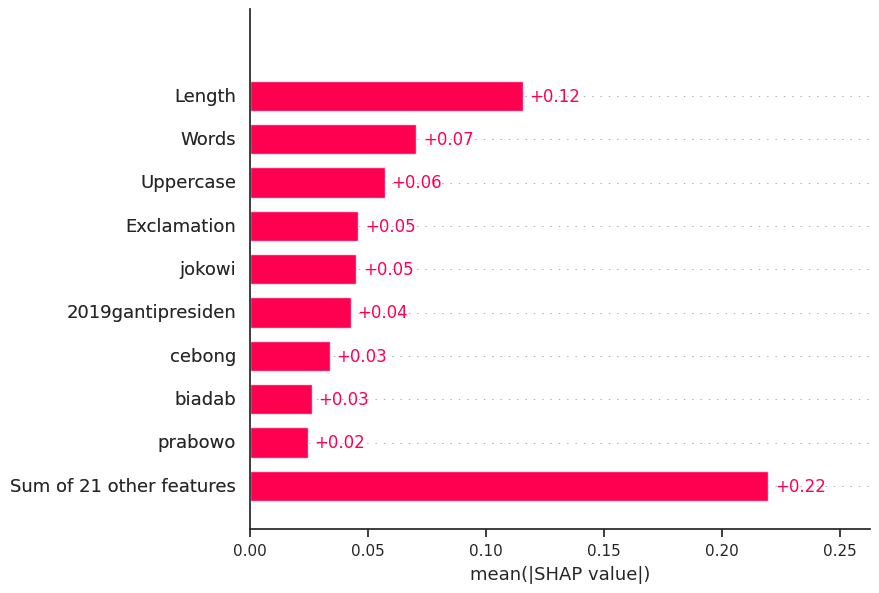

In [ ]:
shap.plots.bar(hs_lr_shap_values, show=False)
plt.savefig('LogReg_HS_feature_importance.pdf', bbox_inches="tight")
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


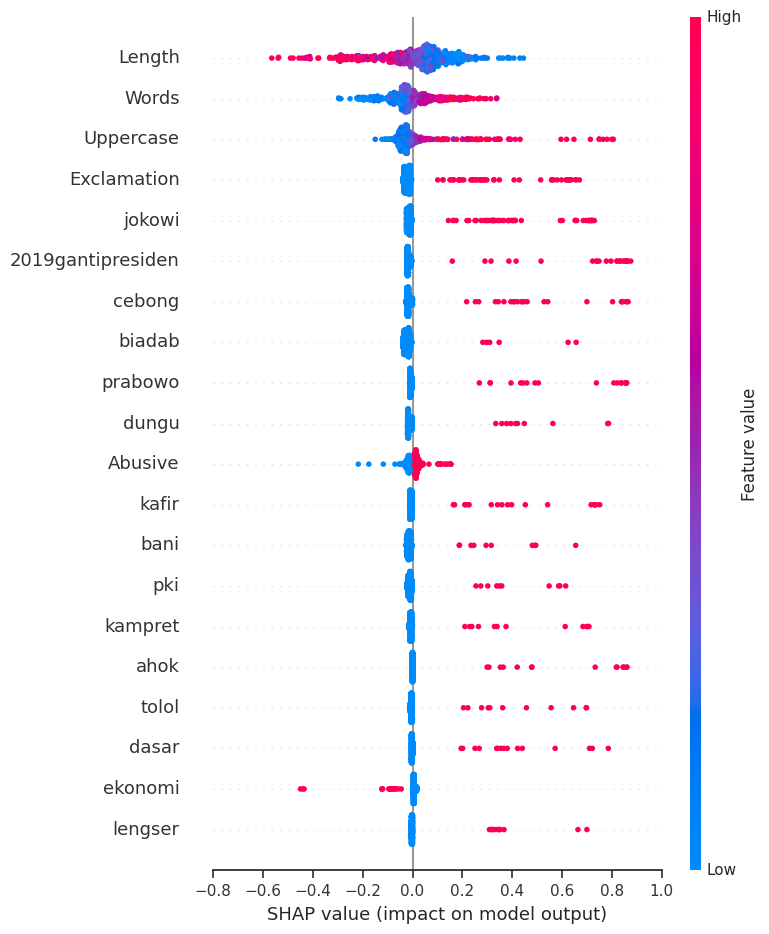

In [ ]:
shap.summary_plot(hs_lr_shap_values, show=False)
plt.savefig('LogReg_HS_summary_plot.pdf')
plt.show()

## XGBoost

In [ ]:
hs_xgbc_model = XGBClassifier()
hs_xgbc_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
# Fits the explainer
hs_xgbc_explainer = shap.Explainer(hs_xgbc_model.predict, X_test)
# Calculates the SHAP values - It takes some time
hs_xgbc_shap_values = hs_xgbc_explainer(X_test)

Permutation explainer: 660it [01:07,  8.24it/s]                         


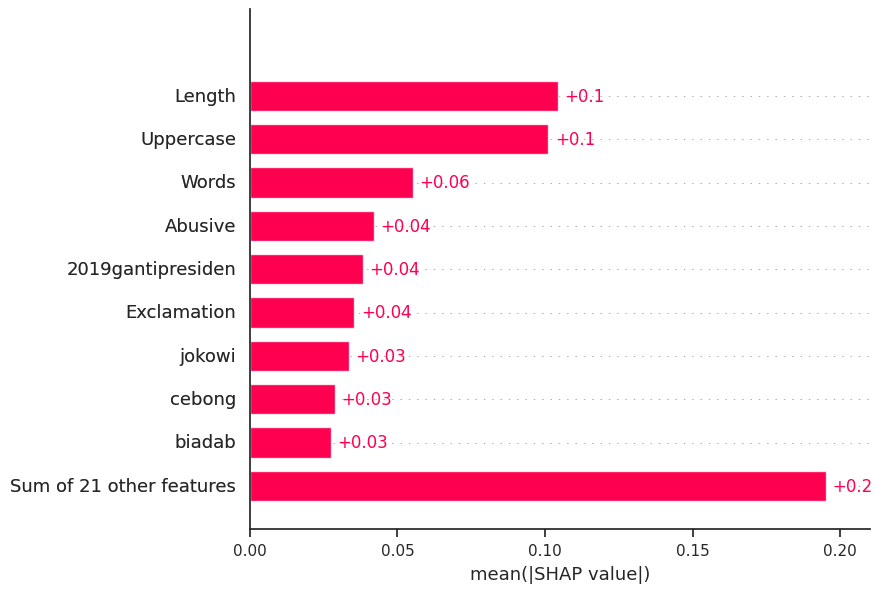

In [ ]:
shap.plots.bar(hs_xgbc_shap_values, show=False)
plt.savefig('XGB_HS_feature_importance.pdf', bbox_inches="tight")
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


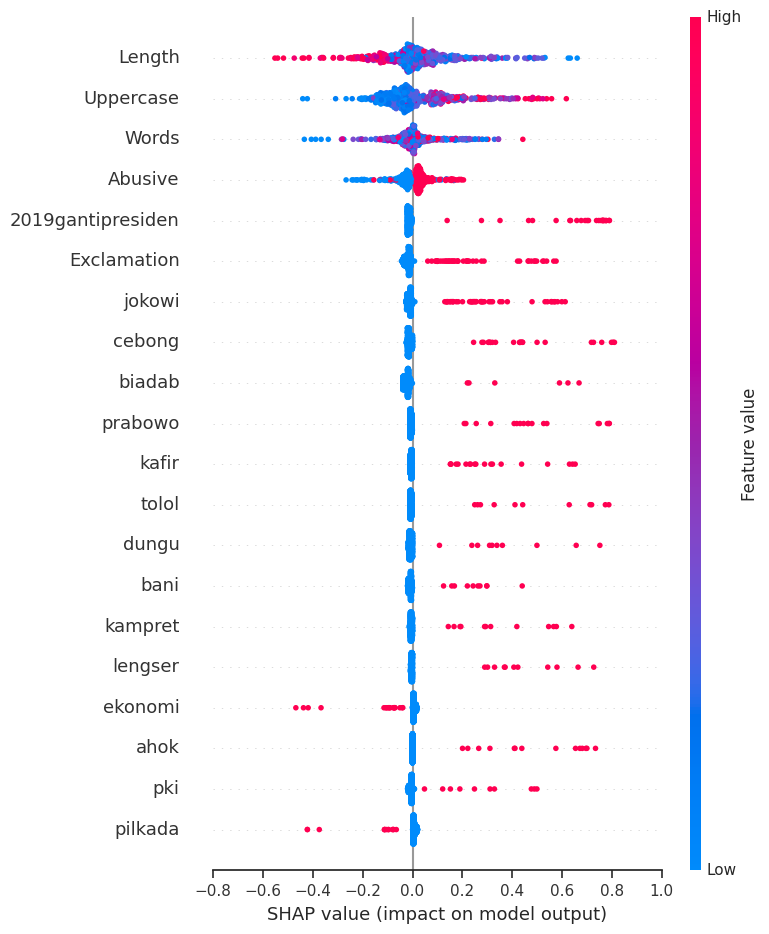

In [ ]:
shap.summary_plot(hs_xgbc_shap_values, show=False)
plt.savefig('XGB_HS_summary_plot.pdf', bbox_inches="tight")
plt.show()

## CatBoost

In [ ]:
hs_cat_model = CatBoostClassifier(iterations=17,
                                  learning_rate=1,
                                  depth=2).fit(
                                      Pool(
                                          data=X_train,
                                          label=y_train), 
                                      ).fit(X_train, y_train)

0:	learn: 0.6248033	total: 49.3ms	remaining: 789ms
1:	learn: 0.5996540	total: 51.5ms	remaining: 386ms
2:	learn: 0.5774108	total: 54.3ms	remaining: 254ms
3:	learn: 0.5575335	total: 55.6ms	remaining: 181ms
4:	learn: 0.5343948	total: 56.6ms	remaining: 136ms
5:	learn: 0.5217918	total: 57.5ms	remaining: 105ms
6:	learn: 0.5077785	total: 58.6ms	remaining: 83.7ms
7:	learn: 0.4997623	total: 59.7ms	remaining: 67.2ms
8:	learn: 0.4919787	total: 60.9ms	remaining: 54.2ms
9:	learn: 0.4851337	total: 62ms	remaining: 43.4ms
10:	learn: 0.4790564	total: 62.9ms	remaining: 34.3ms
11:	learn: 0.4746945	total: 63.8ms	remaining: 26.6ms
12:	learn: 0.4708195	total: 64.7ms	remaining: 19.9ms
13:	learn: 0.4648360	total: 65.7ms	remaining: 14.1ms
14:	learn: 0.4610789	total: 66.6ms	remaining: 8.88ms
15:	learn: 0.4601972	total: 67.7ms	remaining: 4.23ms
16:	learn: 0.4567799	total: 68.8ms	remaining: 0us
0:	learn: 0.6248033	total: 1.25ms	remaining: 20.1ms
1:	learn: 0.5996540	total: 2.64ms	remaining: 19.8ms
2:	learn: 0.5774

In [ ]:
# Fits the explainer
hs_cat_explainer = shap.Explainer(hs_cat_model.predict, X_test)
# Calculates the SHAP values - It takes some time
hs_cat_shap_values = hs_cat_explainer(X_test)

Permutation explainer: 660it [00:30, 14.20it/s]                         


In [ ]:
shap.plots.bar(hs_cat_shap_values, show=False)
plt.savefig('CatBoost_HS_feature_importance.pdf', bbox_inches="tight")
plt.show()

In [ ]:
shap.summary_plot(hs_cat_shap_values, show=False)
plt.savefig('CatBoost_HS_summary_plot.pdf', bbox_inches="tight")
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


## MLP

In [ ]:
hs_mlpc_model = MLPClassifier(random_state=1, max_iter=300)
hs_mlpc_model.fit(X_train, y_train)

MLPClassifier(max_iter=300, random_state=1)

In [ ]:
# Fits the explainer
hs_mlpc_explainer = shap.Explainer(hs_mlpc_model.predict, X_test)
# Calculates the SHAP values - It takes some time
hs_mlpc_shap_values = hs_mlpc_explainer(X_test)

Permutation explainer: 660it [01:01,  8.95it/s]                         


In [ ]:
shap.plots.bar(hs_mlpc_shap_values, show=False)
plt.savefig('MLP_HS_feature_importance.pdf', bbox_inches="tight")
plt.show()

In [ ]:
shap.summary_plot(hs_mlpc_shap_values, show=False)
plt.savefig('MLP_HS_summary_plot.pdf', bbox_inches="tight")
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


## SVM

In [ ]:
hs_svc_model = SVC()
hs_svc_model.fit(X_train, y_train)

In [ ]:
# Fits the explainer
hs_svc_explainer = shap.Explainer(hs_svc_model.predict, X_test)
# Calculates the SHAP values - It takes some time
hs_svc_shap_values = hs_svc_explainer(X_test)

In [ ]:
shap.plots.bar(hs_svc_shap_values)

In [ ]:
shap.summary_plot(hs_svc_shap_values)

In [63]:
hs_lscm_model = LinearSVC().fit(X_train, y_train)

Liblinear failed to converge, increase the number of iterations.


In [64]:
# Fits the explainer
hs_lscm_explainer = shap.Explainer(hs_lscm_model.predict, X_test)
# Calculates the SHAP values - It takes some time
hs_lscm_shap_values = hs_lscm_explainer(X_test)

Permutation explainer: 660it [00:30, 14.75it/s]                         


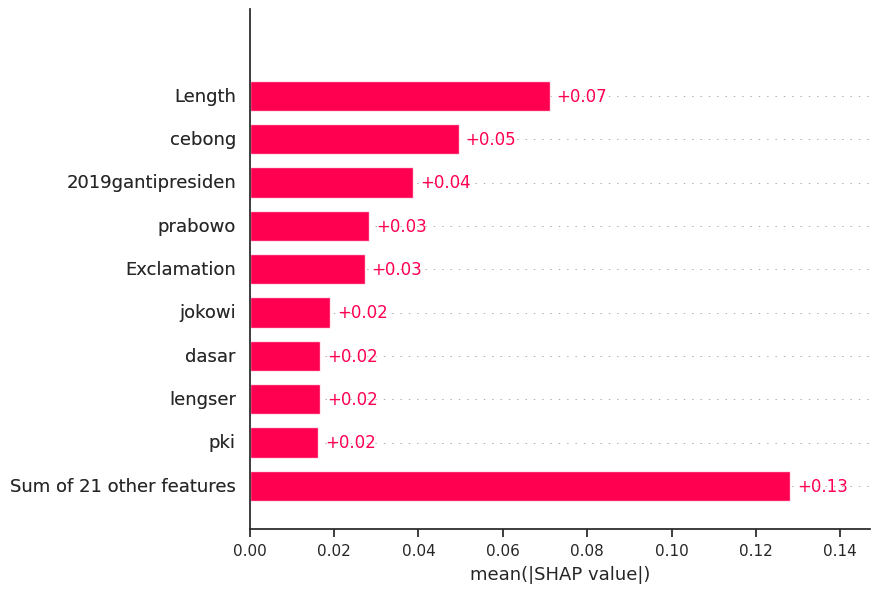

In [65]:
shap.plots.bar(hs_lscm_shap_values, show=False)
plt.savefig('SVM_HS_feature_importance.pdf', bbox_inches="tight")
plt.show()

In [66]:
shap.summary_plot(hs_lscm_shap_values, show=False)
plt.savefig('SVM_HS_summary_plot.pdf', bbox_inches="tight")
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


# Abusive

In [67]:
a_df = features_df.loc[:, A_features[:30]]
a_df['A'] = ex_features_df.loc[:, "Abusive"]
a_df

cebong  2019gantipresiden  Exclamation  jokowi  prabowo  ahok  lengser  \
0          0                  0            0       0        0     0        0   
1          0                  0            0       0        0     0        0   
2          0                  0            0       0        0     0        0   
3          0                  0            0       0        0     0        0   
4          0                  0            0       0        0     0        0   
...      ...                ...          ...     ...      ...   ...      ...   
3287       0                  0            0       0        0     0        0   
3288       0                  1            1       0        0     0        0   
3289       0                  0            0       0        0     1        0   
3290       0                  0            0       0        0     0        0   
3291       0                  0            0       0        0     0        0   

      Length  Abusive  budaya  ...  katolik  tipu  bom  biadab  ekonomi  \
0         74        0       0  ...        0     0    0       0        0   
1         77        0       0  ...        0     0    0       0        0   
2        135        0       0  ...        0     0    0       0        0   
3        133        1       0  ...        0     0    0       0        0   
4        174        1       0  ...        0     0    0       0        0   
...      ...      ...     ...  ...      ...   ...  ...     ...      ...   
3287      49        1       0  ...        0     0    0       0        0   
3288     118        0       0  ...        0     0    0       0        0   
3289      52        1       0  ...        0     0    0       0        0   
3290      61        1       0  ...        0     0    0       0        0   
3291     232        1       0  ...        0     0    0       0        0   

      kristen  pki  pilkada  sontoloyo  A  
0           0    0        0          0  0  
1           0    0        0          0  0  
2           0    0        0          0  0  
3           0    0        0          0  1  
4           0    0        0          0  1  
...       ...  ...      ...        ... ..  
3287        0    0        0          0  1  
3288        0    0        0          0  0  
3289        0    0        0          0  1  
3290        0    0        0          0  1  
3291        0    0        0          0  1  

[3292 rows x 31 columns]

In [68]:
shap.initjs()

Xa = hs_df.loc[:, hs_df.columns != 'HS']
ya = hs_df['HS']
Xa_train, Xa_test, ya_train, ya_test = train_test_split(Xa, ya, test_size = 0.2)

## LogReg

In [69]:
a_lr_model = LogisticRegression()
a_lr_model.fit(Xa_train, ya_train)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression()

In [70]:
# Fits the explainer
a_lr_explainer = shap.Explainer(a_lr_model.predict, Xa_test)
# Calculates the SHAP values - It takes some time
a_lr_shap_values = a_lr_explainer(Xa_test)

Permutation explainer: 660it [00:29, 13.65it/s]                         


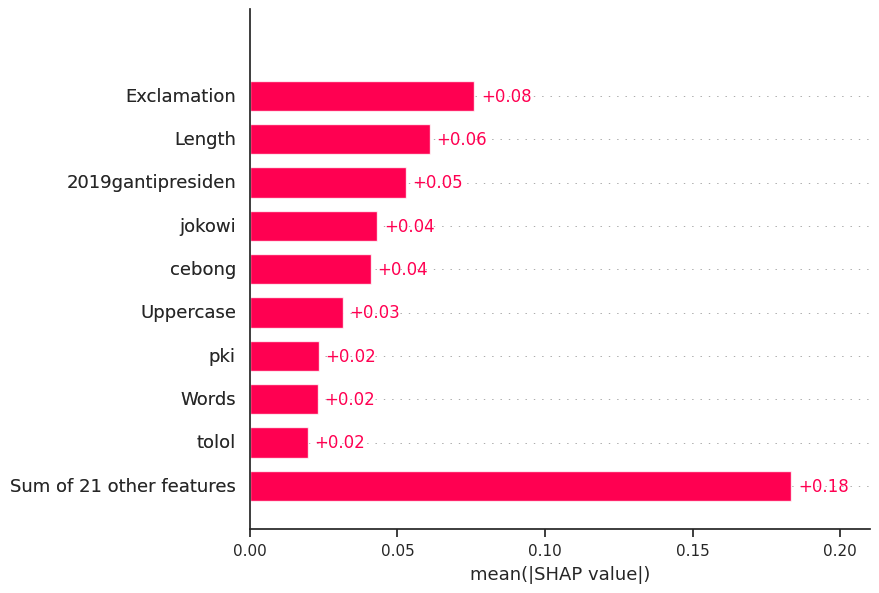

In [71]:
shap.plots.bar(a_lr_shap_values, show=False)
plt.savefig('LogReg_A_feature_importance.pdf', bbox_inches="tight")
plt.show()

In [73]:
shap.summary_plot(a_lr_shap_values, show=False)
plt.savefig('LogReg_A_summary_plot.pdf', bbox_inches="tight")
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


## XGBoost

In [74]:
a_xgbc_model = XGBClassifier()
a_xgbc_model.fit(Xa_train, ya_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [75]:
# Fits the explainer
a_xgbc_explainer = shap.Explainer(a_xgbc_model.predict, Xa_test)
# Calculates the SHAP values - It takes some time
a_xgbc_shap_values = a_xgbc_explainer(Xa_test)

Permutation explainer: 660it [01:02,  8.80it/s]                         


In [79]:
shap.plots.bar(a_xgbc_shap_values, show=False)
plt.savefig('XGB_A_feature_importance.pdf', bbox_inches="tight")
plt.show()

In [78]:
shap.summary_plot(a_xgbc_shap_values, show=False)
plt.savefig('XGB_A_summary_plot.pdf', bbox_inches="tight")
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


## CatBoost

In [80]:
a_cat_model = CatBoostClassifier(iterations=17,
                                  learning_rate=1,
                                  depth=2
                                  ).fit(
                                      Pool(
                                          data=Xa_train,
                                          label=ya_train) 
                                      )

0:	learn: 0.6304913	total: 2.51ms	remaining: 40.1ms
1:	learn: 0.5958520	total: 10.1ms	remaining: 76ms
2:	learn: 0.5704407	total: 13.7ms	remaining: 63.9ms
3:	learn: 0.5594733	total: 14.7ms	remaining: 47.8ms
4:	learn: 0.5434071	total: 32.4ms	remaining: 77.7ms
5:	learn: 0.5287137	total: 37.9ms	remaining: 69.5ms
6:	learn: 0.5153893	total: 43.7ms	remaining: 62.4ms
7:	learn: 0.5027304	total: 50.4ms	remaining: 56.7ms
8:	learn: 0.4976056	total: 64.6ms	remaining: 57.5ms
9:	learn: 0.4897003	total: 69.2ms	remaining: 48.5ms
10:	learn: 0.4832257	total: 74.1ms	remaining: 40.4ms
11:	learn: 0.4784732	total: 79.6ms	remaining: 33.2ms
12:	learn: 0.4717634	total: 85.5ms	remaining: 26.3ms
13:	learn: 0.4672569	total: 89.8ms	remaining: 19.2ms
14:	learn: 0.4629017	total: 93ms	remaining: 12.4ms
15:	learn: 0.4573821	total: 95.1ms	remaining: 5.95ms
16:	learn: 0.4544417	total: 97.6ms	remaining: 0us


In [81]:
# Fits the explainer
a_cat_explainer = shap.Explainer(a_cat_model.predict, Xa_test)
# Calculates the SHAP values - It takes some time
a_cat_shap_values = a_cat_explainer(Xa_test)

Permutation explainer: 660it [00:40, 11.77it/s]                         


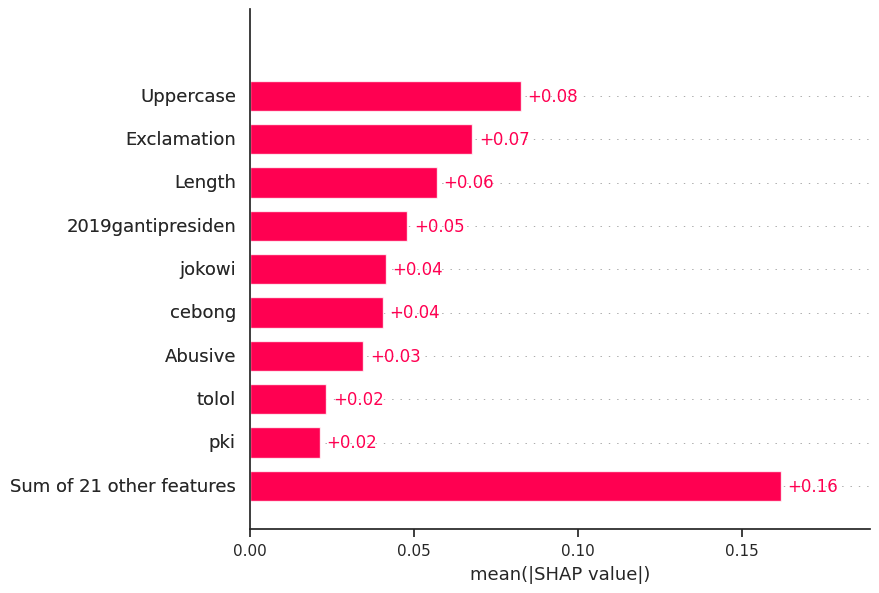

In [82]:
shap.plots.bar(a_cat_shap_values, show=False)
plt.savefig('CatBoost_A_feature_importance.pdf', bbox_inches="tight")
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


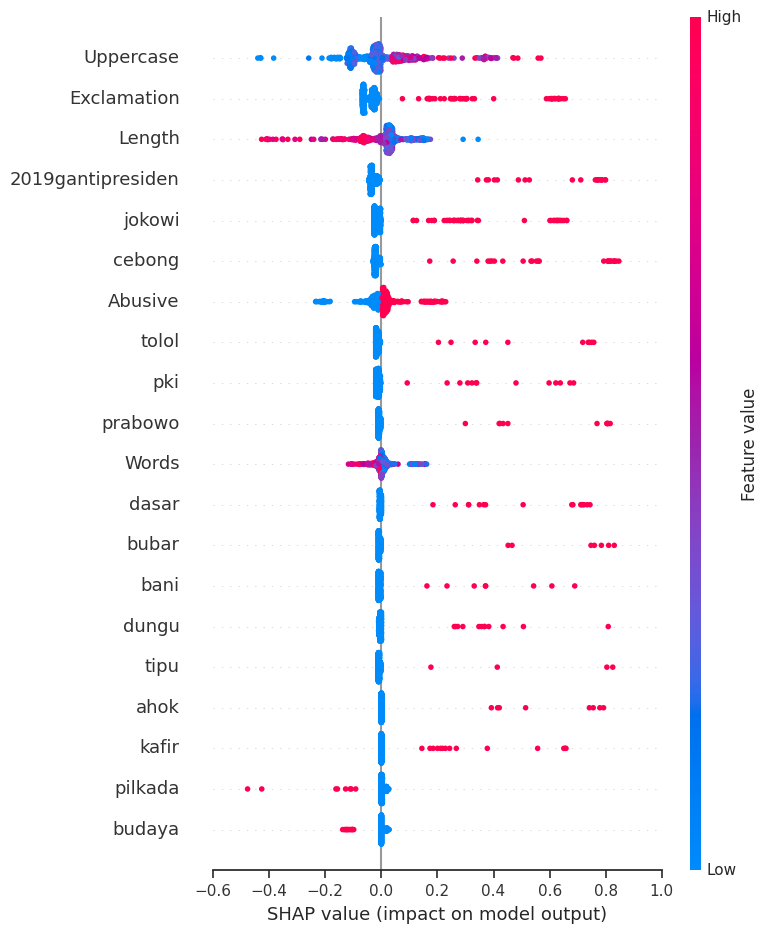

In [83]:
shap.summary_plot(a_cat_shap_values, show=False)
plt.savefig('CatBoost_A_summary_plot.pdf', bbox_inches="tight")
plt.show()

## MLP

In [84]:
a_mlpc_model = MLPClassifier(random_state=1, max_iter=300)
a_mlpc_model.fit(Xa_train, ya_train)

MLPClassifier(max_iter=300, random_state=1)

In [85]:
# Fits the explainer
a_mlpc_explainer = shap.Explainer(a_mlpc_model.predict, Xa_test)
# Calculates the SHAP values - It takes some time
a_mlpc_shap_values = a_mlpc_explainer(Xa_test)

Permutation explainer: 660it [00:42, 12.44it/s]


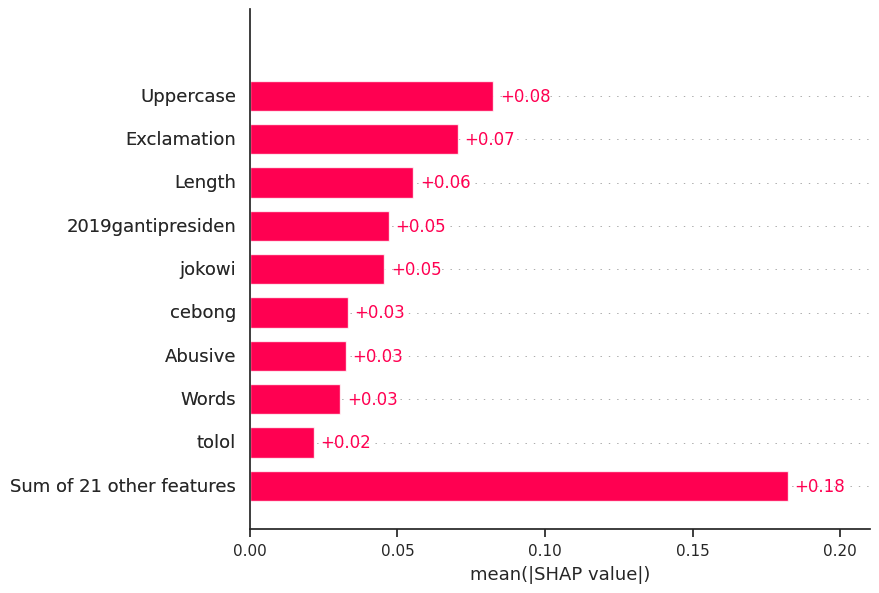

In [86]:
shap.plots.bar(a_mlpc_shap_values, show=False)
plt.savefig('MLP_A_feature_importance.pdf', bbox_inches="tight")
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


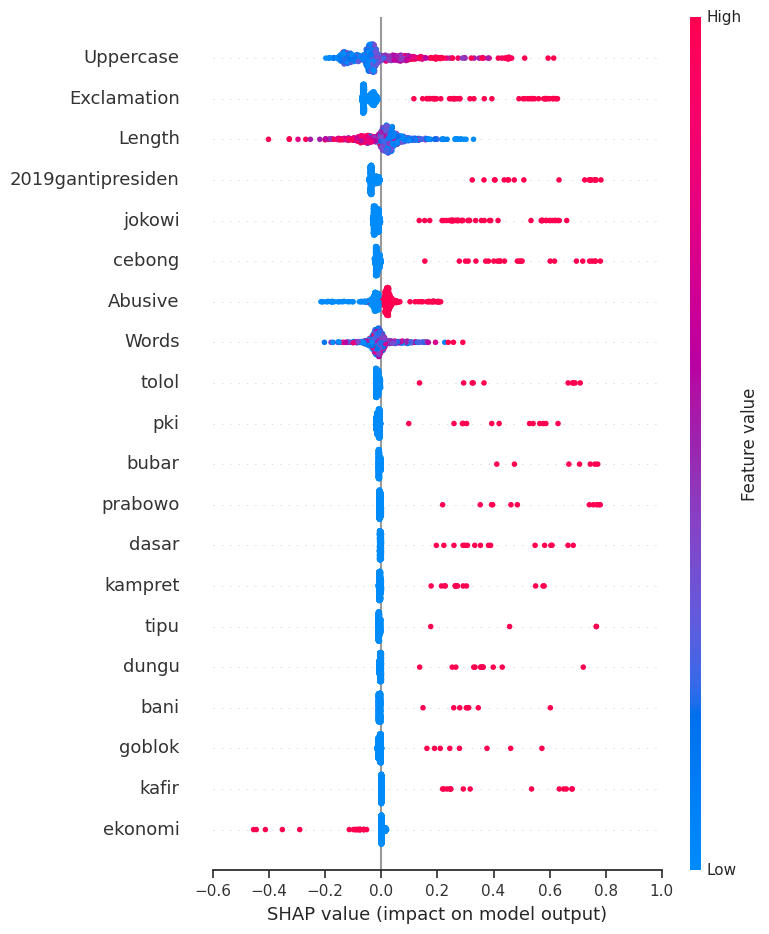

In [87]:
shap.summary_plot(a_mlpc_shap_values, show=False)
plt.savefig('MLP_A_summary_plot.pdf', bbox_inches="tight")
plt.show()

## SVM

In [ ]:
a_svc_model = SVC()
a_svc_model.fit(Xa_train, ya_train)

In [ ]:
# Fits the explainer
a_svc_explainer = shap.Explainer(a_svc_model.predict, Xa_test)
# Calculates the SHAP values - It takes some time
a_svc_shap_values = a_svc_explainer(Xa_test)

In [ ]:
shap.plots.bar(a_svc_shap_values)

In [ ]:
shap.summary_plot(a_svc_shap_values)

In [89]:
a_lsvm_model = LinearSVC().fit(Xa_train, ya_train)

Liblinear failed to converge, increase the number of iterations.


In [90]:
# Fits the explainer
a_lsvm_explainer = shap.Explainer(a_lsvm_model.predict, Xa_test)
# Calculates the SHAP values - It takes some time
a_lsvm_shap_values = a_lsvm_explainer(Xa_test)

Permutation explainer: 660it [00:29, 12.87it/s]                         


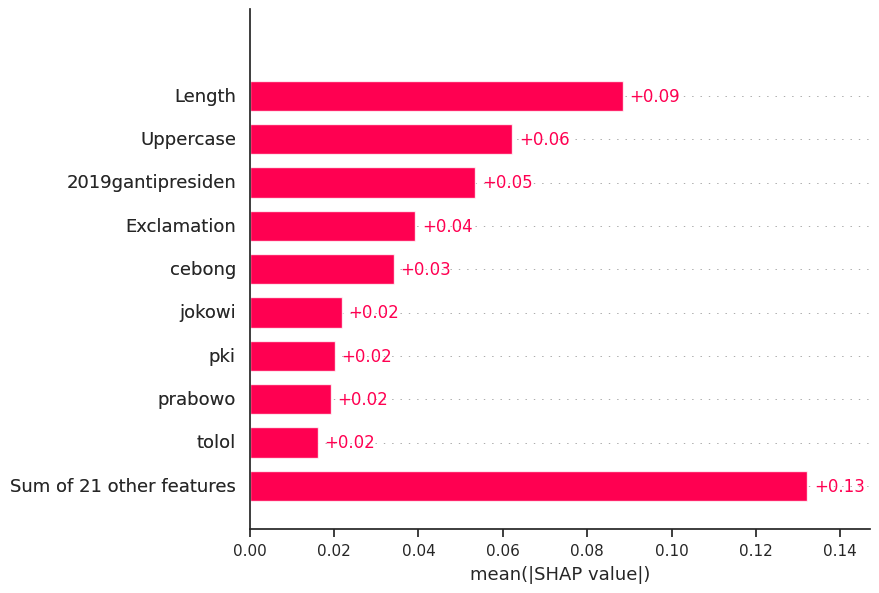

In [95]:
shap.plots.bar(a_lsvm_shap_values, show=False)
plt.savefig('SVM_A_feature_importance.pdf', bbox_inches="tight")
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


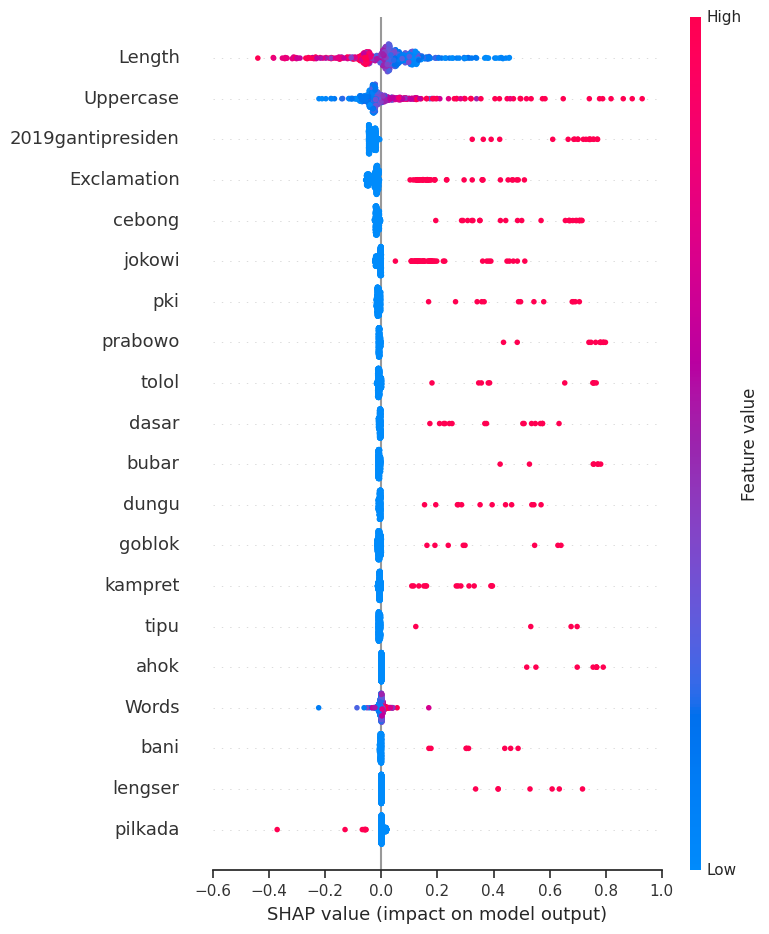

In [96]:
shap.summary_plot(a_lsvm_shap_values, show=False)
plt.savefig('SVM_A_summary_plot.pdf', bbox_inches="tight")
plt.show()